## Import

#### requirements 필요 라이브러리 다운로드

In [1]:
!pip install -r requirements.txt

In [32]:
import pandas as pd
import random
import os
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer

from sklearn.preprocessing import RobustScaler
from autogluon.tabular import TabularDataset, TabularPredictor

In [33]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(37) # Seed 고정

## Data Load

In [34]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [35]:
train_df.head()

,PRODUCT_ID,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
0,TRAIN_0000,1,0.531957,T100304,T_31,2.0,95.0,0.0,45.0,10.0,...,0.000008,0.000003,0.191408,0.000008,0.001210,0.000021,0.000003,0.000002,0.189,0.000006
1,TRAIN_0001,1,0.531105,T100306,T_31,2.0,96.0,0.0,45.0,10.0,...,0.000008,0.000003,0.188993,0.000032,0.000644,0.000041,0.000002,0.000003,0.185,0.000029
2,TRAIN_0002,1,0.532292,T100306,T_31,2.0,95.0,0.0,45.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TRAIN_0003,1,0.528141,T100306,T_31,2.0,87.0,0.0,45.0,10.0,...,0.000007,0.000003,0.189424,0.000034,0.000678,0.000043,0.000004,0.000003,0.188,0.000031
4,TRAIN_0004,1,0.532289,T100306,T_31,2.0,95.0,0.0,45.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
# 이를 통해 상품코드가 라인별로 비슷한걸 묶어서 공유한다는걸 확인하였다.
train_df.groupby(['LINE'])['PRODUCT_CODE'].value_counts()

LINE     PRODUCT_CODE
T010305  A_31             66
T010306  A_31             76
T050304  A_31             86
T050307  A_31             66
T100304  T_31            400
         O_31              4
T100306  T_31            430
         O_31              4
Name: PRODUCT_CODE, dtype: int64

<Axes: >

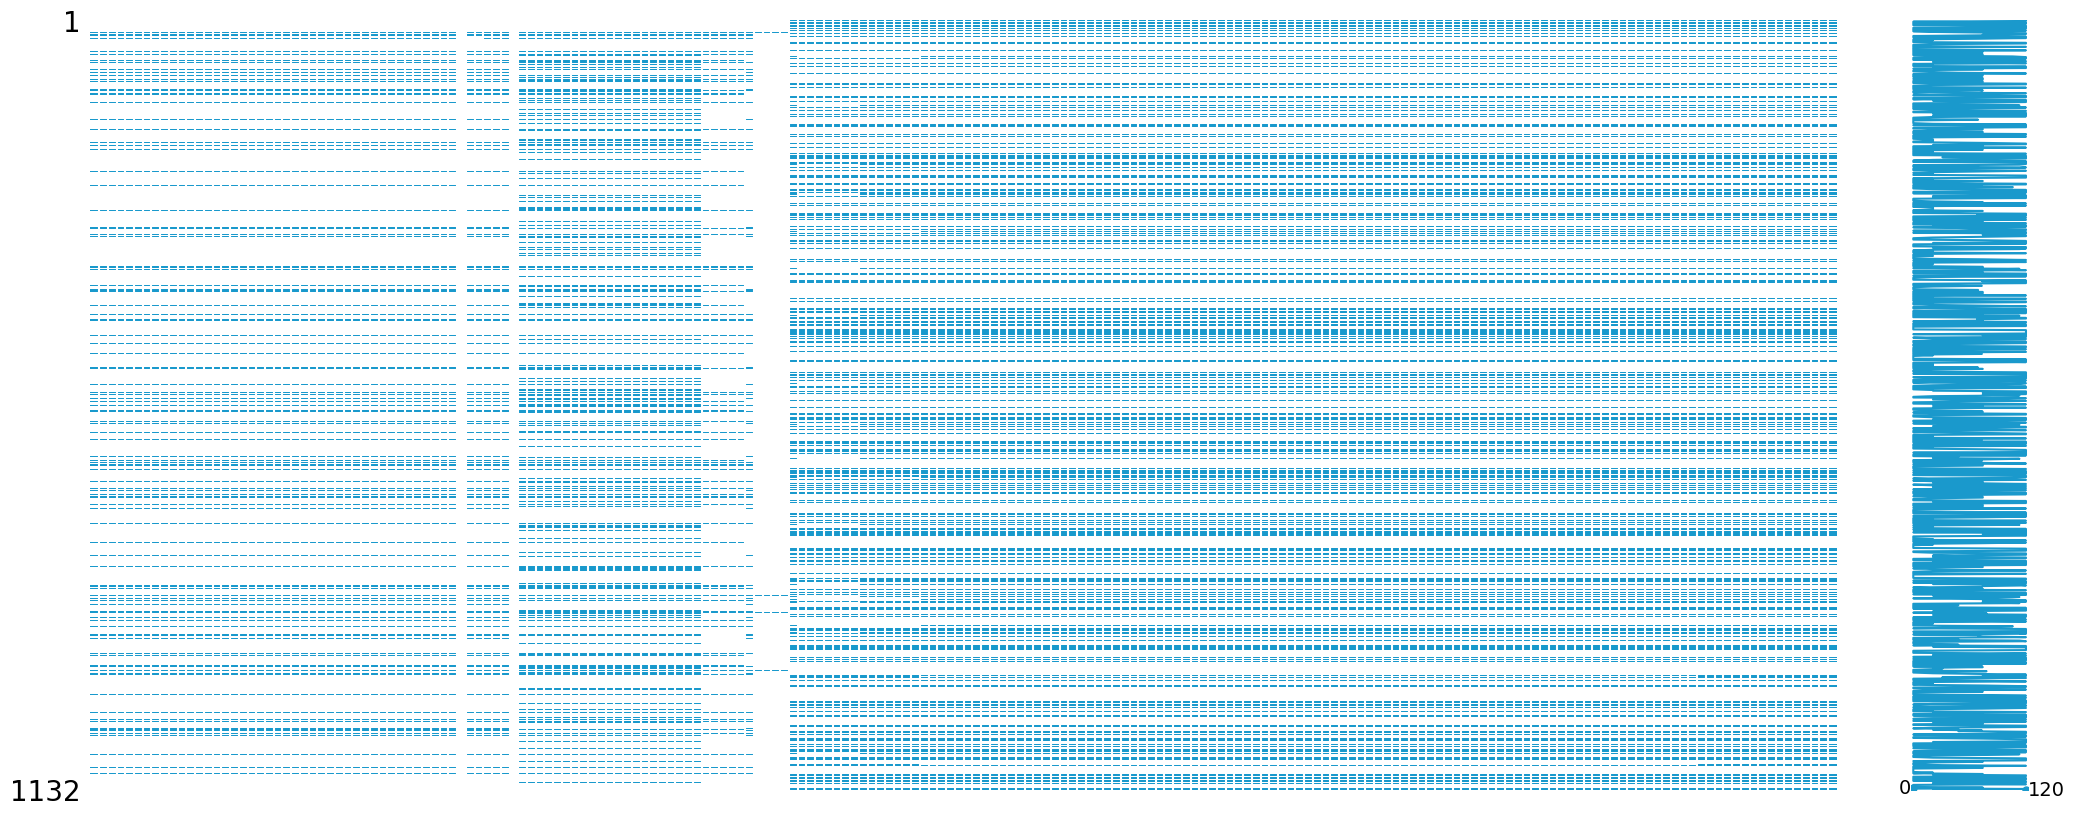

In [52]:
import missingno as msno
msno.matrix(df=train_df.iloc[:, 2800:3000], color=(0.1, 0.6, 0.8))

In [53]:
train_df['LINE'].value_counts()

T100306    434
T100304    404
T050304     86
T010306     76
T010305     66
T050307     66
Name: LINE, dtype: int64

In [54]:
train_df.loc[:,'LINE']

0       T100304
1       T100306
2       T100306
3       T100306
4       T100306
         ...   
1127    T050304
1128    T100304
1129    T100306
1130    T010306
1131    T100304
Name: LINE, Length: 1132, dtype: object

## Data Pre-processing

In [55]:
# train df
train_1 = train_df[train_df['LINE'].isin(['T100306','T100304'])]
train_2 = train_df[train_df['LINE'].isin(['T050304','T010306','T010305','T050307'])]

# test df
test_1 = test_df[test_df['LINE'].isin(['T100306','T100304'])]
test_2 = test_df[test_df['LINE'].isin(['T050304','T010306','T010305','T050307'])]

#### 결측치 보간

In [56]:
def remove_line_nan(line):
    col_idx = line.columns[5:]
    removed_col = []
    for idx in col_idx:
        if(line[idx].isnull().sum() == line.shape[0]):
            removed_col.append(idx)
    result = line.drop(removed_col,axis=1)
    print(len(removed_col))
    return result,removed_col

# train set
train_line_1,deleted_col_1 = remove_line_nan(train_1)
train_line_2,deleted_col_2 = remove_line_nan(train_2)

# test set
test_line_1 = test_1.drop(deleted_col_1,axis=1)
test_line_2 = test_2.drop(deleted_col_2,axis=1)

2194
1206


In [57]:
# line1
train_x_1 = train_line_1.drop(columns=['PRODUCT_ID', 'Y_Quality'])
train_y_1 = train_line_1['Y_Class']

test_x_1 = test_line_1.drop(columns=['PRODUCT_ID'])
test_product_id_1 = test_line_1['PRODUCT_ID']
test_col_1 = test_line_1.drop(columns=['PRODUCT_ID'])

# line2
train_x_2 = train_line_2.drop(columns=['PRODUCT_ID', 'Y_Quality'])
train_y_2 = train_line_2['Y_Class']

test_x_2 = test_line_2.drop(columns=['PRODUCT_ID'])
test_product_id_2 = test_line_2['PRODUCT_ID']

test_col_2= test_line_2.drop(columns=['PRODUCT_ID'])

#### KNN 보간
- line1에 대해서 보간하였다.
- line2에 대해서는 데이터가 작아 0으로 채워주었다.

In [58]:
imputer = KNNImputer(n_neighbors=77)

knn_train_x_col = train_x_1[['Y_Class','LINE','PRODUCT_CODE']]
knn_train_x_temp = train_x_1.drop(columns=['Y_Class', 'LINE','PRODUCT_CODE'])
knn_train_x = imputer.fit_transform(knn_train_x_temp)

train_x_1 = pd.DataFrame(knn_train_x, columns=knn_train_x_temp.columns ,index = knn_train_x_temp.index)


knn_test_x_col = test_col_1[['LINE','PRODUCT_CODE']]
knn_test_x_temp = test_col_1.drop(columns=[ 'LINE','PRODUCT_CODE'])
knn_test_x = imputer.transform(knn_test_x_temp)

test_x_1 = pd.DataFrame(knn_test_x, columns=knn_test_x_temp.columns , index = knn_test_x_temp.index)

In [59]:
train_x_1['Y_Class']=knn_train_x_col['Y_Class']
train_x_1['LINE']=knn_train_x_col['LINE']
train_x_1['PRODUCT_CODE']=knn_train_x_col['PRODUCT_CODE']
test_x_1['LINE']=knn_test_x_col['LINE']
test_x_1['PRODUCT_CODE']=knn_test_x_col['PRODUCT_CODE']

In [60]:
# line2
train_x_2 = train_x_2.fillna(0)
test_x_2 = test_x_2.fillna(0)

In [61]:
# qualitative to quantitative
qual_col = ['LINE', 'PRODUCT_CODE']

def encoder(train_x,test_x):
    for i in qual_col:
        le = LabelEncoder()
        le = le.fit(train_x[i])
        train_x[i] = le.transform(train_x[i])

        for label in np.unique(test_x[i]): 
            if label not in le.classes_: 
                le.classes_ = np.append(le.classes_, label)
        test_x[i] = le.transform(test_x[i]) 

encoder(train_x_1,test_x_1)
encoder(train_x_2,test_x_2)

In [64]:
# 최종 처리된 row와 column수 이다.
print(train_x_1.shape,train_x_2.shape)

(838, 1135) (294, 2123)


#### Scailing
- robust scaler를 이용해 아웃라이어에 둔감하게 만들었다.

In [17]:
# autogluon 학습을 위한 데이터 형태로 변환
scaled_train_1 = TabularDataset(train_x_1)
scaled_train_2 = TabularDataset(train_x_2)

test1 = TabularDataset(test_x_1)
test2 = TabularDataset(test_x_2)

In [18]:
scaler1 = RobustScaler(quantile_range=(20.0, 80.0))
scaler2 = RobustScaler(quantile_range=(10.0, 90.0))
X_scaled1 = scaler1.fit_transform(scaled_train_1.drop(columns=['Y_Class']))
X_scaled2 = scaler2.fit_transform(scaled_train_2.drop(columns=['Y_Class']))
b1 = scaler1.inverse_transform(X_scaled1)
b2 = scaler2.inverse_transform(X_scaled2)
scaled_test_1 = pd.DataFrame(b1, columns=scaled_train_1.drop(columns=['Y_Class']).columns)
scaled_test_2 = pd.DataFrame(b2, columns=scaled_train_2.drop(columns=['Y_Class']).columns)

In [19]:
scaled_test_1['Y_Class'] = train_y_1.values
scaled_test_2['Y_Class'] = train_y_2.values

## Autogluon Model

In [20]:
scaled_train_1 = scaled_test_1
scaled_train_2 = scaled_test_2

In [21]:
predictor1 = TabularPredictor(label='Y_Class', eval_metric='f1_macro').fit(scaled_train_1,num_gpus=1)

No path specified. Models will be saved in: "AutogluonModels/ag-20230326_003703/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20230326_003703/"
AutoGluon Version:  0.7.0
Python Version:     3.8.9
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Jan 25 16:41:43 UTC 2023
Train Data Rows:    838
Train Data Columns: 1134
Label Column: Y_Class
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	3 unique label values:  [1, 2, 0]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Train Data Class Count: 3
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    22649.0 MB
	Train Data (Origi

In [22]:
ld_board = predictor1.leaderboard(scaled_train_1, silent=True)

ld_board

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMXT,0.937774,0.635097,0.038612,0.023122,6.896888,0.038612,0.023122,6.896888,1,True,4
1,LightGBM,0.935368,0.636062,0.024916,0.011471,15.242354,0.024916,0.011471,15.242354,1,True,5
2,ExtraTreesEntr,0.933765,0.613960,0.142709,0.093995,1.410158,0.142709,0.093995,1.410158,1,True,10
3,RandomForestGini,0.933038,0.624164,0.136571,0.095428,1.603805,0.136571,0.095428,1.603805,1,True,6
4,LightGBMLarge,0.933000,0.623704,0.087294,0.016245,34.308852,0.087294,0.016245,34.308852,1,True,13
5,ExtraTreesGini,0.930590,0.603596,0.140044,0.089978,1.206032,0.140044,0.089978,1.206032,1,True,9
6,RandomForestEntr,0.930310,0.595230,0.138919,0.096640,1.744543,0.138919,0.096640,1.744543,1,True,7
7,KNeighborsDist,0.928017,0.624612,0.024714,0.013364,0.184832,0.024714,0.013364,0.184832,1,True,2
8,NeuralNetTorch,0.874561,0.606220,0.416137,0.378540,7.008335,0.416137,0.378540,7.008335,1,True,12
9,XGBoost,0.866477,0.649176,0.068303,0.015981,4.593392,0.068303,0.015981,4.593392,1,True,11


In [23]:
predictor2 = TabularPredictor(label='Y_Class', eval_metric='f1_macro',).fit(scaled_train_2,num_gpus=1)

No path specified. Models will be saved in: "AutogluonModels/ag-20230326_003835/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20230326_003835/"
AutoGluon Version:  0.7.0
Python Version:     3.8.9
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Jan 25 16:41:43 UTC 2023
Train Data Rows:    294
Train Data Columns: 2122
Label Column: Y_Class
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	3 unique label values:  [1, 0, 2]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Train Data Class Count: 3
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    20706.11 MB
	Train Data (Orig

In [24]:
ld_board = predictor2.leaderboard(scaled_train_2, silent=True)

ld_board

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.970264,0.848003,1.240985,0.939408,30.886400,0.008275,0.002165,2.469424,2,True,14
1,LightGBMXT,0.956064,0.779950,0.034417,0.016467,4.868344,0.034417,0.016467,4.868344,1,True,4
2,ExtraTreesEntr,0.955130,0.761428,0.120147,0.074636,1.739818,0.120147,0.074636,1.739818,1,True,10
3,ExtraTreesGini,0.951660,0.740718,0.117660,0.071167,1.808546,0.117660,0.071167,1.808546,1,True,9
4,RandomForestGini,0.948393,0.730275,0.121295,0.071685,1.806090,0.121295,0.071685,1.806090,1,True,6
5,XGBoost,0.942942,0.714306,0.068944,0.014649,5.330744,0.068944,0.014649,5.330744,1,True,11
6,RandomForestEntr,0.941724,0.695811,0.110852,0.075316,1.846464,0.110852,0.075316,1.846464,1,True,7
7,KNeighborsDist,0.941019,0.703497,0.026396,0.014886,0.449493,0.026396,0.014886,0.449493,1,True,2
8,LightGBMLarge,0.939374,0.699346,0.042770,0.026358,15.374055,0.042770,0.026358,15.374055,1,True,13
9,LightGBM,0.938589,0.693442,0.034794,0.017587,5.715389,0.034794,0.017587,5.715389,1,True,5


## Inference

In [25]:
y_scaled1 = scaler1.transform(test1)
y_scaled2 = scaler2.transform(test2)
b1 = scaler1.inverse_transform(y_scaled1)
b2 = scaler2.inverse_transform(y_scaled2)
scaled_test_1 = pd.DataFrame(b1, columns=test1.columns, index=test1.index)
scaled_test_2 = pd.DataFrame(b2, columns=test2.columns, index=test2.index)

In [26]:
# 예측하기
pred_y_1 = predictor1.predict(scaled_test_1)
pred_y_2 = predictor2.predict(scaled_test_2)

In [27]:
test_result1 = pd.concat([test_product_id_1,pred_y_1],axis=1)
test_result2 = pd.concat([test_product_id_2,pred_y_2],axis=1)

## Submit

In [28]:
submit = pd.read_csv('sample_submission.csv')

In [29]:
for index, row in test_result1.iterrows():
    product_id = row['PRODUCT_ID']
    y_class = row['Y_Class']
    submit.loc[submit['PRODUCT_ID'] == product_id, 'Y_Class'] = y_class

for index, row in test_result2.iterrows():
    product_id = row['PRODUCT_ID']
    y_class = row['Y_Class']
    submit.loc[submit['PRODUCT_ID'] == product_id, 'Y_Class'] = y_class

In [30]:
submit['Y_Class'].value_counts()

1    393
2     95
0     47
Name: Y_Class, dtype: int64

In [31]:
submit.to_csv('./knn_robust_inverse_line246junpark.csv', index=False)